In [1]:
import parse_data.prepare_data as prepare_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import globals
import data_strings
import data_extraction.get_indices as get_indices
import seaborn as sns
import parse_data.identify_filepaths as identify_filepaths
import data_extraction.data_saving as data_saving

## Plot a heatmap of P(Choose High) for each individual wall in solo sessions
- Two variants: pooled data across all individuals (error is the standard error of a proportion, see below), and means of data across individuals (error is SEM)

Graph 1:
- Shows the pooled mean (combining all data across players)
- seaborn

Graph 2:
- As above, but using mpl directly

Graph 3: 
- Shows the mean of individual player means
- Error bars represent the standard error of the mean (SEM) across player means


We prefer to use the mean of individual player means, because we want the variance to reflect the variation in population between individuals, not just focussing on the trial level


### Access data

In [2]:
loading = True

In [7]:
if loading:
    # load previously prepared data
    trial_lists = data_saving.load_data('trial_lists_solo_standard_50')
else:

    data_folder = data_strings.DATA_FOLDER

    # combine consecutive solo sessions (pre- and post- for an individual player)
    json_filenames_social, json_filenames_solo = identify_filepaths.get_filenames()
    _, trial_lists = prepare_data.prepare_data(data_folder, json_filenames_solo, combine=False)
    print(len(trial_lists))
    trial_lists = [trial_lists[i] + trial_lists[i+1] for i in range(0, len(trial_lists), 2)]


### Filter the data
- Only include HighLow trials
- Remove the first 5 trials of each pre- sessions (even numbered indices only)

In [8]:
dropped_trials = 5

In [9]:
analysis_results = {
    session_id: {

            # trial list and filtered trial indices
            'trial_lists': {
                'full_session': None,
                'drop_first_5': None,
                'high_low_filtered': None,
            },

            # chosen wall numbers and whether high or low
            'choice_data' : {
                'wall_numbers': None,
                'chose_high': None,
                'probability_chose_high': None  # array of values from walls 1 to 8
            }
            

        }
    for session_id in np.arange(len(trial_lists))
}

In [10]:
for session_id in analysis_results.keys():
    
    player_data = analysis_results[session_id]
    trial_list = trial_lists[session_id]

    player_data['trial_lists']['full_session'] = trial_list
    player_data['trial_lists']['drop_first_5'] = trial_list[dropped_trials:] 

    trial_list_filtered = player_data['trial_lists']['drop_first_5']
    player_data['trial_lists']['high_low_filtered'] = [trial_list_filtered[i]
                                                        for i in get_indices.get_trials_trialtype(trial_list_filtered, globals.HIGH_LOW)]
    
    # print(len(player_data['trial_lists']['high_low_filtered']))

### Find the wall numbers chosen and whether these were high or low

In [11]:
for session_id in analysis_results.keys():
    
    player_data = analysis_results[session_id]
    trial_list = player_data['trial_lists']['high_low_filtered']

    player_data['choice_data']['wall_numbers'] = get_indices.get_chosen_walls(trial_list).astype(int)
    player_data['choice_data']['chose_high'] = get_indices.was_high_wall_chosen(trial_list)

    # print(len(player_data['choice_data']['chose_high']))

### Find each player's probability of choosing High

In [12]:
for session_id in analysis_results.keys():
    
    player_data = analysis_results[session_id]
    wall_numbers = player_data['choice_data']['wall_numbers']
    chose_high = player_data['choice_data']['chose_high']

    wall_probabilities = np.full(8, np.nan)

    # specify min bins == highest integer value + 1
    # slice from index 1 because 0 will always be counted, but is not relevant
    counts = np.bincount(wall_numbers, minlength=9)[1:]  # count occurrences of 1-8
    chosen_counts = np.bincount(wall_numbers[chose_high], minlength=9)[1:]  # count True occurrences

    mask = counts > 0  # Avoid division by zero
    wall_probabilities[mask] = chosen_counts[mask] / counts[mask]

    player_data['choice_data']['probability_chose_high'] = wall_probabilities

In [13]:
# quick tests

# # analysis_results[1]['choice_data']['wall_numbers'],analysis_results[1]['choice_data']['chose_high']

# # np.sum(analysis_results[1]['choice_data']['chose_high'])/analysis_results[1]['choice_data']['chose_high'].size

# # np.sum(analysis_results[1]['choice_data']['wall_numbers'] == 8)

### Flatten data across players for pooled mean

In [14]:
wall_number_list = [analysis_results[session_id]['choice_data']['wall_numbers']
 for session_id in analysis_results
 ]
chose_high_list = [analysis_results[session_id]['choice_data']['chose_high']
 for session_id in analysis_results
 ]


wall_numbers = np.concatenate(wall_number_list).astype(int)
chose_high = np.concatenate(chose_high_list)

In [15]:
# # with for loops

# wall_probabilities_test = np.full(8, np.nan)
# for wall_num in range(1,9):
#     wall_num_mask = wall_numbers == wall_num
#     relevant_chose_high = chose_high[wall_num_mask]
#     probability_chose_high = np.sum(relevant_chose_high)/relevant_chose_high.size

#     wall_index = wall_num - 1
#     wall_probabilities_test[wall_index] = probability_chose_high



In [16]:
# more efficient code with vectorised functions

wall_probabilities = np.full(8, np.nan)

# specify min bins == highest integer value + 1
# slice from index 1 because 0 will always be counted, but is not relevant
counts = np.bincount(wall_numbers, minlength=9)[1:]  # count occurrences of 1-8
chosen_counts = np.bincount(wall_numbers[chose_high], minlength=9)[1:]  # count True occurrences

mask = counts > 0  # Avoid division by zero
wall_probabilities[mask] = chosen_counts[mask] / counts[mask]

#### Get errors bars for pooled mean
- following the formula:
 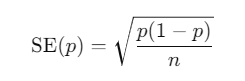

In [17]:
# get error bars

standard_error = np.sqrt((wall_probabilities * (1 - wall_probabilities)) / len(wall_number_list))

#### Plot for pooled mean

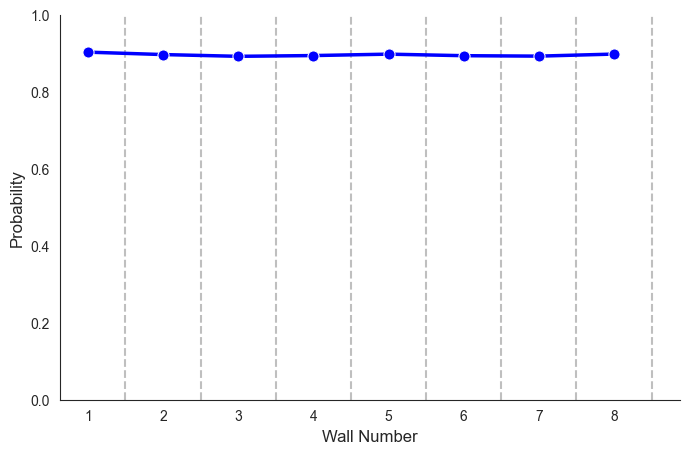

In [18]:
wall_numbers = np.arange(1,9)
wall_probabilities = wall_probabilities

# set seaborn style
sns.set_style("white", {"axes.grid": False})

# create figure and axis
plt.figure(figsize=(8, 5))

# plot vertical dashed grey lines for each categorical x value
for x in wall_numbers:
    plt.axvline(x=x+0.5, color='grey', linestyle='dashed', alpha=0.5)

# plot the probability line with markers
sns.lineplot(x=wall_numbers, y=wall_probabilities, marker='o', markersize=8, linewidth=2.5, color="b")

# Customize labels and title
plt.xlabel("Wall Number", fontsize=12)
plt.ylabel("Probability", fontsize=12)
# plt.title("Probability of Choosing High by Wall Number", fontsize=14)

# set y-axis for probability
plt.ylim([0,1])

# adjust x-axis ticks to match categorical values
plt.xticks(wall_numbers)

# Remove top and right borders
sns.despine(top=True, right=True)

# show the plot
plt.show()

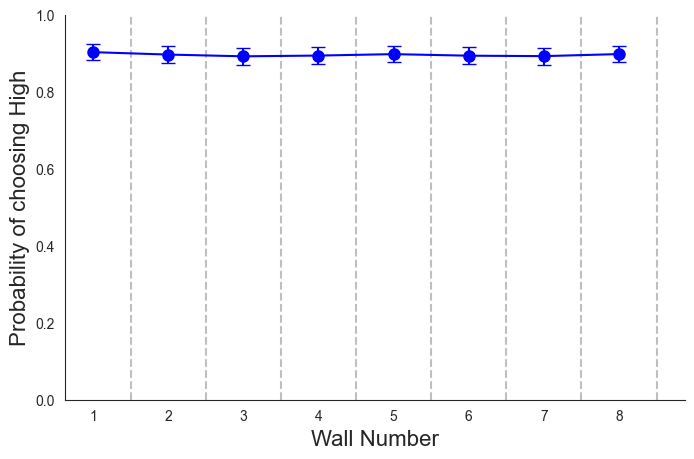

In [19]:
# repeated but for mpl

# Sample probability data (replace with actual values)
wall_numbers = np.arange(1,9)
wall_probabilities = wall_probabilities
errors = standard_error

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot vertical dashed grey lines for each categorical x value
for x in wall_numbers:
    ax.axvline(x=x+0.5, color='grey', linestyle='dashed', alpha=0.5)

# Plot the probability line with markers
# ax.plot(wall_numbers, wall_probabilities, marker='o', markersize=8, linewidth=2.5, color="b")
plt.errorbar(wall_numbers, wall_probabilities, yerr=errors, fmt='-o', capsize=5, color='b', label="Mean of Means", markersize=8)


# Customize labels and title
ax.set_xlabel("Wall Number", fontsize=16)
ax.set_ylabel("Probability of choosing High", fontsize=16)
# ax.set_title("Probability of Choosing High by Wall Number", fontsize=14)

# Adjust x-axis ticks to match categorical values
ax.set_xticks(wall_numbers)

# set y-axis for probability
plt.ylim([0,1])

# Remove top and right borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Show the plot
plt.show()

### repeat for mean of individual player means

In [20]:
mean_probability_list = [analysis_results[session_id]['choice_data']['probability_chose_high']
 for session_id in analysis_results
 ]
mean_probability_array = np.asarray(mean_probability_list)

In [24]:
wall_probabilities_overall = np.nanmean(mean_probability_array, axis=0)
std_dev_overall = np.nanstd(mean_probability_array, ddof=1, axis=0)  # Standard deviation
sem_overall = std_dev_overall / np.sqrt(len(mean_probability_list))  # Standard error of mean

#### Plot for mean of individual player proportions 

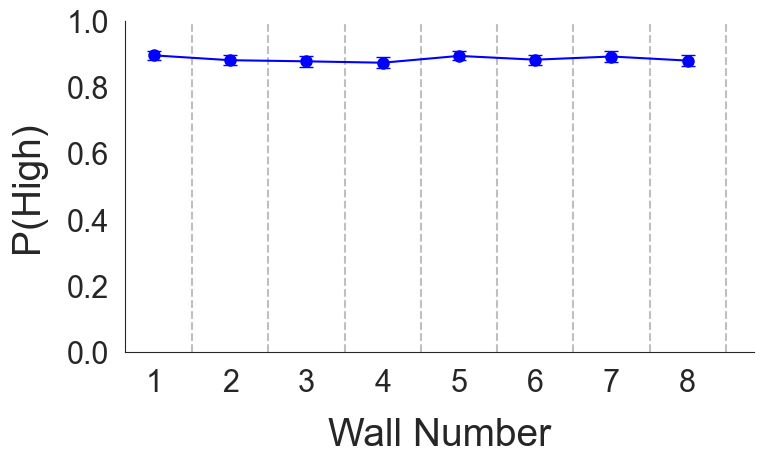

In [34]:
# repeated but for mpl

# Sample probability data (replace with actual values)
wall_numbers = np.arange(1,9)
wall_probabilities = wall_probabilities_overall
errors = sem_overall

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot vertical dashed grey lines for each categorical x value
for x in wall_numbers:
    ax.axvline(x=x+0.5, color='grey', linestyle='dashed', alpha=0.5)

# Plot the probability line with markers
# ax.plot(wall_numbers, wall_probabilities, marker='o', markersize=8, linewidth=2.5, color="b")

plt.errorbar(wall_numbers, wall_probabilities, yerr=errors, fmt='-o', capsize=5, color='b', label="Mean of Means", markersize=8)


# Customize labels and title
ax.set_xlabel("Wall Number", fontsize=22)
ax.set_ylabel("P(High)", fontsize=22)
# ax.set_title("Probability of Choosing High by Wall Number", fontsize=14)

# Adjust x-axis ticks to match categorical values
plt.xticks(wall_numbers, fontsize=14)
plt.yticks(fontsize=14)

# set y-axis for probability
plt.ylim([0,1])


# Remove top and right borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Increase font sizes for all elements for poster format
plt.xlabel("Wall Number", fontsize=28, labelpad=15)
plt.ylabel("P(High)", fontsize=28, labelpad=15)
plt.xticks(wall_numbers, fontsize=22)
plt.yticks(fontsize=22)
ax.tick_params(axis='both', which='major', length=8, width=2)
ax.tick_params(axis='both', which='minor', length=5, width=1)
ax.xaxis.label.set_size(28)
ax.yaxis.label.set_size(28)
ax.title.set_size(30)
plt.tight_layout(pad=2.0)
plt.show()